# 1. Import Libraries

In [41]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# 2. Read Dataset

In [42]:
root_dir = 'weather-dataset/dataset'
img_paths = []
labels = []
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(
        sorted(os.listdir(root_dir))
    )
}
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir,class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir,img_filename)
        img_path = img_paths.append(img_path)
        labels.append(label_idx)

In [43]:
classes.items()

dict_items([(0, 'dew'), (1, 'fogsmog'), (2, 'frost'), (3, 'glaze'), (4, 'hail'), (5, 'lightning'), (6, 'rain'), (7, 'rainbow'), (8, 'rime'), (9, 'sandstorm'), (10, 'snow')])

# 3. Train, Val, Test split

In [44]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [45]:
len(X_train)

4391

## Because it is a big dataset, I will train with 1/3 root dataset

In [46]:
X_train, temp1, y_train, temp1 = train_test_split(
    X_train, y_train,
    test_size=0.67,
    random_state=seed,
    shuffle=is_shuffle
)
X_test, temp1, y_test, temp1 = train_test_split(
    X_train, y_train,
    test_size=0.67,
    random_state=seed,
    shuffle=is_shuffle
)
X_val, temp1, y_val, temp1 = train_test_split(
    X_train, y_train,
    test_size=0.67,
    random_state=seed,
    shuffle=is_shuffle
)


In [47]:
len(X_train), len(X_test), len(X_val)

(1449, 478, 478)

# 4. Create pytorch dataset

In [48]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

# 5. Create data preprocessing fucntion

In [49]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

# 6. Create dataloader

In [50]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [51]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## Demo some images

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


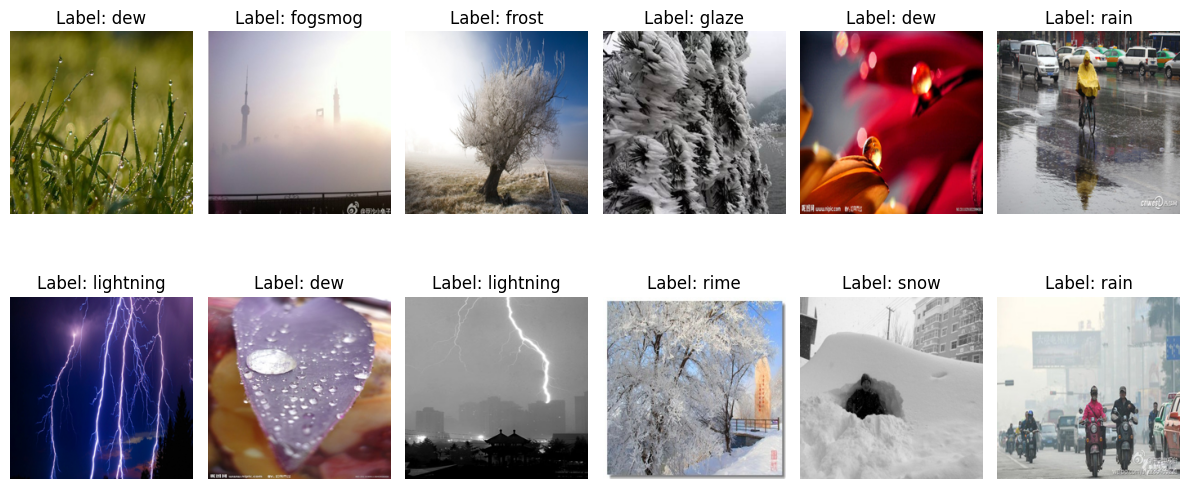

In [52]:
import torchvision
num_rows= 2
num_cols=6

train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
# Create a figure and axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop through the rows and columns
for row in range(num_rows):
    for col in range(num_cols):
        # Display the image and label
        img = train_features[row*num_cols+col].permute(1, 2, 0)
        label = train_labels[row*num_cols+col].item()
        
        # Set the current axis and plot the image
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Label: {classes[label]}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# 7. Create Model

In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

In [54]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [55]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [56]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


# 8. TRAINING

In [57]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [58]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

## Loss + Optimizer

In [59]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [60]:
# start to train
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.9082	Val loss: 2.3773
EPOCH 2:	Train loss: 1.3472	Val loss: 2.3430
EPOCH 3:	Train loss: 0.9653	Val loss: 1.9870
EPOCH 4:	Train loss: 0.6438	Val loss: 1.2860
EPOCH 5:	Train loss: 0.4004	Val loss: 0.5379
EPOCH 6:	Train loss: 0.2423	Val loss: 0.5552
EPOCH 7:	Train loss: 0.1508	Val loss: 0.2092
EPOCH 8:	Train loss: 0.0812	Val loss: 0.0618
EPOCH 9:	Train loss: 0.0567	Val loss: 0.0714
EPOCH 10:	Train loss: 0.0431	Val loss: 0.0414
EPOCH 11:	Train loss: 0.0397	Val loss: 0.2227
EPOCH 12:	Train loss: 0.0491	Val loss: 0.2150
EPOCH 13:	Train loss: 0.0299	Val loss: 0.0220
EPOCH 14:	Train loss: 0.0247	Val loss: 0.0239
EPOCH 15:	Train loss: 0.0275	Val loss: 0.1409
EPOCH 16:	Train loss: 0.0286	Val loss: 0.0106
EPOCH 17:	Train loss: 0.0201	Val loss: 0.0253
EPOCH 18:	Train loss: 0.0139	Val loss: 0.0071
EPOCH 19:	Train loss: 0.0145	Val loss: 0.0191
EPOCH 20:	Train loss: 0.0160	Val loss: 0.3291
EPOCH 21:	Train loss: 0.0831	Val loss: 0.0441
EPOCH 22:	Train loss: 0.0164	Val loss: 0.01

# 9. Visualize Train Loss, Val Loss

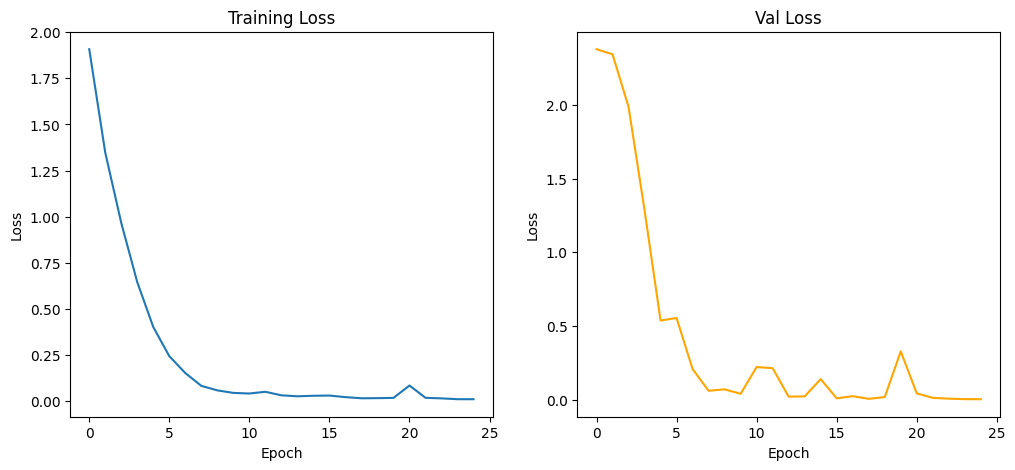

In [61]:
fig, ax  = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# 10. Evaluation

In [63]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  1.0
Test accuracy:  1.0
